In [3]:
import copy
import numpy as np
import matplotlib.pyplot as plt
from tempfile import NamedTemporaryFile
import base64
from matplotlib import animation
from scipy.misc import logsumexp
% matplotlib inline

VIDEO_TAG = """<video controls>
 <source src="data:video/x-m4v;base64,{0}" type="video/mp4">
</video>"""

def anim_to_html(anim):
    if not hasattr(anim, '_encoded_video'):
        with NamedTemporaryFile(suffix='.mp4') as f:
            anim.save(f.name, fps=20, extra_args=['-vcodec', 'libx264', '-pix_fmt', 'yuv420p'])
            video = open(f.name, "rb").read()
        anim._encoded_video = base64.b64encode(video)
    
    return VIDEO_TAG.format(anim.to_html5_video())

from IPython.display import HTML

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim_to_html(anim))

Some plotting functions that will proved to be useful all along this notebook.

In [4]:
def plot_gaussian(mean, variance, x_min=-10, x_max=10):
    x = np.linspace(x_min, x_max, 10000)
    y = gaussian_pdf(x, mean, variance)
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
    plt.plot(x, y, label='mean='+str(mean)+', var='+str(variance))
    plt.grid()
    plt.legend(loc='best')
    plt.plot()
    

def plot_gmm(means, variances, weights, show_components=True, x_min=-10, x_max=10):
    x = np.linspace(x_min, x_max, 10000)
    y = np.zeros_like(x)
    for k in range(len(weights)):
        y1 = weights[k] * gaussian_pdf(x, means[k], variances[k])
        y += y1
        if show_components:
            plt.plot(x, y1, '--', linewidth=1.41)
        
    plt.xlabel('$x$')
    plt.ylabel('$p(x)$')
    plt.plot(x, y, color='k')    
    plt.grid()


The Gaussian density function is defined as:
$$
    \DeclareMathOperator{\e}{exp}
    p(x | \mu, \beta) = \frac{1}{\sqrt{2\pi\beta}} \e\{ \frac{-(x - \mu)^2}{2\beta} \}
$$
* $\mu$ is the **mean** of the Gaussian density 
* $\beta$ is the **variance** of the Gaussian density

In [5]:
def gaussian_pdf(x, mean, var):    
    return np.exp((-0.5/var) * ((x - mean) ** 2)) / np.sqrt(2 * np.pi * var)

and it looks like this:

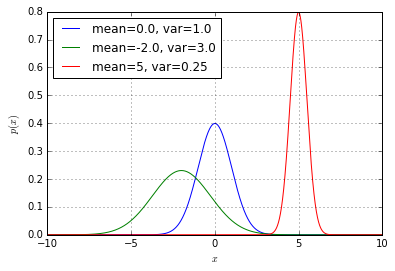

In [6]:
plot_gaussian(0., 1.)
plot_gaussian(-2., 3.)
plot_gaussian(5, .25)

The Gaussian density is a very simple function, however, in most case of interest the densities we try to model have a complex shape that cannot be expressed with a simple formula. A solution is to assume that our complex density is made of $K$ Gaussian densities. This is called a Gaussian Mixture Model (GMM) and it is defined as:
$$
    p(x|\boldsymbol{\mu}, \boldsymbol{\beta}, \boldsymbol{\pi}) = \sum_{k=1}^{K} \pi_k p(x|\mu_k, \beta_k)
$$
* $\boldsymbol{\mu}$ is the vector of $K$ means
* $\boldsymbol{\beta}$ is the vector of $K$ variances
* $\boldsymbol{\pi}$ is the vector of $K$ weights such that $\sum_{k=1}^K \pi_k = 1$ 

In [7]:
def gmm_pdf(x, means, variances, weights):
    y = np.zeros_like(x)
    for k in range(len(weights)):
        y += weights[k] * gaussian_pdf(x, means[k], variances[k])
    return y

Here is an example of GMM:

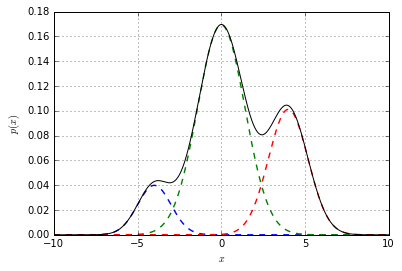

In [8]:
means = [-4.0, 0.0, 4.0]  
variances = [1.0, 2.0, 1.4]
weights = [0.1, 0.6, 0.3]
plot_gmm(means, variances, weights)

Let's generate a collection of points from the GMM previouls shown.

In [9]:
K = 3  # no.of Gaussian components
means = [-4.0, 0.0, 4.0]  # means of components
variances = [1.0, 2.0, 1.4]
weights = [0.1, 0.6, 0.3]  # weights of components
N = 1000  # total no. of data points

X = []  # all the data
for k in range(K):
    Xk = np.random.normal(means[k], np.sqrt(variances[k]), int(N * weights[k]))
    X.append(Xk)
X = np.hstack(X)

This data points will be our training data. In real scenario, we do not know what was the parameters of the true model and we use the training data to infer the parameters of the model. For GMM the inference can be done with the **Expectation-Maximization** (EM) algorithm. The first step is to create some initial guess for the parameters:

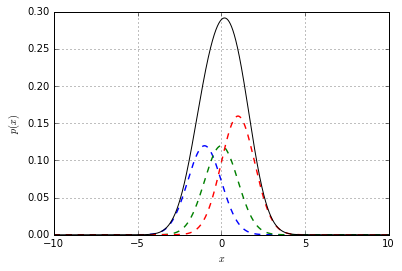

In [10]:
model = {'means': [-1.0, 0.0, 1.0], 'vars': [1.0, 1.0, 1.0], 'weights': [0.3, 0.3, 0.4]}  
plot_gmm(model['means'], model['vars'], model['weights'])

We have assumed here that we know the correct number of components. Remember that in reality this is rarely the case ! Now we just defined a function that is needed by the EM algorithm. This compute the log probability of a point for each Gaussian component of the model:

In [11]:
def gmm_log_likelihood_per_component(X, means, variances, weights):
    """ Evaluate the log-likelihood of the data given the model """
    
    llh = np.zeros(shape=(X.shape[0], len(weights)), dtype=float)
    for k in range(len(weights)):
        llh[:, k] = np.log(weights[k]) + np.log(gaussian_pdf(X, means[k], variances[k]))
    return llh

The EM algorithm is an iterative algorithm that converges toward a (local) maximum of the log-likelihood of the data given the model. Here is the implemenation of one step of the EM: 

In [12]:
def EM_step(means, variances, weights):
    # E-step
    llh_per_comp = gmm_log_likelihood_per_component(X, means, variances, weights)
    norms = logsumexp(llh_per_comp, axis=1)
    resps = np.exp((llh_per_comp.T - norms).T)
    
    llh = norms.sum()       
    
    # M-step
    for k in range(len(weights)):
        means[k] = np.sum((resps[:, k] * X)) / resps[:, k].sum()
        variances[k] = np.sum((resps[:, k] * ((X - means[k]) ** 2))) / resps[:, k].sum()
        weights[k] = np.sum(resps[:, k]) / X.shape[0]     
        
def log_likelihood(means, variances, weights):
    llh_per_comp = gmm_log_likelihood_per_component(X, means, variances, weights)
    norms = logsumexp(llh_per_comp, axis=1)
    return norms.sum()   
    

Train the model with EM algorithm:

In [13]:
# We reinitialize the model so that people can run the cell again without problems.
model = {'means': [-5.0, 0.0, 5.0], 'vars': [1.0, 1.0, 1.0], 'weights': [0.3, 0.3, 0.4]}

threshold = 1e-2
previous_llh = float('-inf')
current_llh = log_likelihood(model['means'], model['vars'], model['weights'])
models = [(copy.deepcopy(model), current_llh)] # We store the model at different step of the training for the plotting.
count = 0
while current_llh - previous_llh > threshold:
    # Do one EM iteration.
    EM_step(model['means'], model['vars'], model['weights'])
    
    # Update the log-likelihood of the model.
    previous_llh = current_llh
    current_llh = log_likelihood(model['means'], model['vars'], model['weights'])
    
    # Just for plotting/logging.
    models.append((copy.deepcopy(model), current_llh))
    count += 1
    
print('Training finished in', count, 'iterations')

###############################
# Animation for EM algorithm. #
###############################
x_min = -10
x_max = 10
x = np.linspace(x_min, x_max, 1000)
fig = plt.figure()
ax = plt.axes(xlim=(x_min, x_max), ylim=(0, .3))
ax.grid()
ax.set_xlabel('$x$')
ax.set_ylabel('$p(x)$')
line, = ax.plot([], [], color='k', lw=2)
ax.plot(X, np.zeros_like(X), 'b+')
llh_text = ax.text(0.02, 0.95, '', transform=ax.transAxes)

def init():
    line.set_data([], [])
    llh_text.set_text('')
    return line,

# animation function.  This is called sequentially
def animate(i):
    model, llh = models[i]
    y = gmm_pdf(x, model['means'], model['vars'], model['weights'])
    line.set_data(x, y)
    llh_text.set_text("log-likelihood: %f" % llh)
    return line,

anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=len(models), interval=250, blit=True)
display_animation(anim)

Training finished in 16 iterations


In [ ]:
prior = {
    'dirichlet': [1., 1., 1.],
    'normal_gamma': [[0., 1., 1., 1.], 
                     [0., 1., 1., 1.],
                     [0., 1., 1., 1.]]
    }

## Gibbs sampling

$$
\Theta = \{ \boldsymbol{\mu}, \boldsymbol{\lambda}, \boldsymbol{\pi} \}
$$

$$
\DeclareMathOperator{\Dir}{Dir}
p(\boldsymbol{\pi}) = \Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha}^{(0)})
$$

$$
\DeclareMathOperator{\Norm}{\mathcal{N}}
\DeclareMathOperator{\Gam}{Gam}
p(\mu_k, \lambda_k) = \Norm(\mu_k \mid \mu_0, (\beta_0 \lambda_k)^{-1}) \Gam(\lambda_k \mid a_0, b_0)
$$

$$
\DeclareMathOperator{\Dir}{Dir}
\DeclareMathOperator{\Norm}{\mathcal{N}}
\DeclareMathOperator{\Gam}{Gam}
\begin{align}
p(\mathbf{x}, \Theta) &= p(\mathbf{X} \mid \Theta)p(\Theta) \\
                      &= \Bigg[ \prod_{i=0}^{N} p(x_i \mid \boldsymbol{\mu}, \boldsymbol{\lambda}, \boldsymbol{\pi}) \Bigg] \Bigg[ \Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha}) \prod_{k=0}^{K} \Norm(\mu_k \mid \mu_0, (\beta \lambda_k)^{-1}) \Gam(\lambda_k \mid a, b) \Bigg]
\end{align}
$$

#### Sampling equations:

##### latent variable $z_i$
$$
\begin{align}
p(z_i \mid \mathbf{x}, \Theta) &= p(z_i \mid x_i, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\lambda}) \\
p(z_i = k \mid x_i, \boldsymbol{\pi}, \boldsymbol{\mu}, \boldsymbol{\lambda}) &= \frac{\pi_k \Norm(x_i \mid \mu_k, \lambda_k)} {\sum_{j=0}^{K} \pi_j \Norm(x_i \mid \mu_j, \lambda_j)}
\end{align}
$$

###### mean and variance 
We define the set of all data point $x_i$  that are assigned to the component $k$ of the mixture as follows:
$$
\mathbf{x}_{(k)} = \{ x_i : z_i = k, \forall i \in \{1,... , N \} \} 
$$
and similarly for the latent variables $\mathbf{z}$:
$$
\mathbf{z}_{(k)} = \{ z_i : z_i = k, \forall i \in \{1,... , N \} \} 
$$

$$
\begin{align}
p(\mu_k, \lambda_k \mid \mathbf{x}, \mathbf{z}, \Theta_{\smallsetminus \{ \mu_k, \lambda_k \} } ) &= p(\mu_k, \lambda_k \mid \mathbf{x}_{(k)}, \mathbf{z}_{(k)}, \Theta_{\smallsetminus \{ \mu_k, \lambda_k \} } ) \\
&= \Norm(\mu_k \mid \mu_n, (\beta_n \lambda_k)^{-1}) \Gam(\lambda_k \mid a_n, b_n)
\end{align}
$$
where:
$$
\begin{align}
\mu_n &= \frac{\beta_0 \mu_0 + N_k m_k} {\beta_0 +  N_k} \\
\beta_n &= \beta_0 + N_k \\
a_n &= a_0 + \frac{N_k}{2} \\
b_n &= b_0 + \frac{1}{2} \sum_{\forall x \in \mathbf{x}_{(k)}} (x - m_k)^2 + \frac{b_0 N_k (m_k - \mu_0)^2}{2(b_0 + N_k)} \\
N_k &= \left\vert \mathbf{x}_{(k)} \right\vert \\
m_k &= \frac{1}{N_k} \sum_{\forall x \in \mathbf{x}_{(k)}} x
\end{align}
$$

##### weights

$$
\begin{align}
p( \boldsymbol{\pi} \mid \mathbf{x}, \mathbf{z}, \Theta_{\smallsetminus \{ \boldsymbol{\pi} \} } ) &= p( \boldsymbol{\pi} \mid \mathbf{z}) \\
&= \Dir(\boldsymbol{\pi} \mid \boldsymbol{\alpha}_n)
\end{align}
$$
where:
$$
\boldsymbol{\alpha}_n[k] = \boldsymbol{\alpha}_0[k] + N_k \; ; \; \forall \, k = 1\dots K 
$$
